This notebook is an implementation of a continuous Hopfield network for the purpose of remembering images.

It uses the continuous updating rule of $\tau_i \frac{dV_i}{dt} = -V_i + g_\beta (u_i) = -V_i + g_\beta (\sum_j W_{ij}V_j)$

Cheat sheet:

- $V$ is a vector of all the neurons. In our case, each neuron represents a pixel where the value is between $[-1, 1]$
- $g_\beta$ is a continuous non-linear function. In our case, we use tanh, which outputs values between $[-1, 1]$
- $W$ is the symmetric weight matrix representing the connections between neurons. $W_{ii} = 0$ and $W_{ij} = W_{ji}$. It is initialized by setting $W_{ij} = V_iV_j$ where $V$ is initialized to the state you want the network to "memorize". If you want the network to remember multiple of these states, simply set $W$ to the sum of all the $W$ matrices, one computed for each state.


In [1]:
import numpy as np

# Grayscale

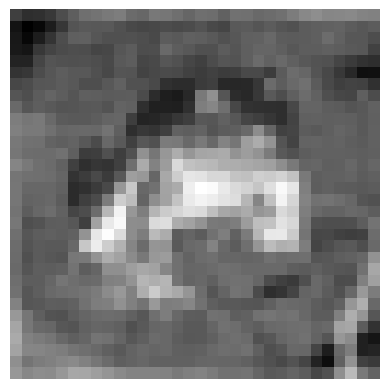

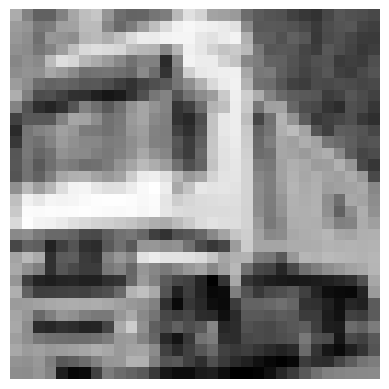

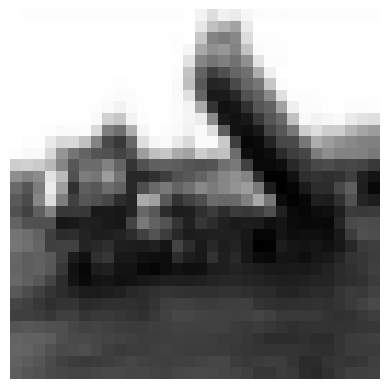

In [392]:
import matplotlib.pyplot as plt

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

num_images = 3
data_file_path = "data_batch_1"
data = unpickle(data_file_path)[b'data']
images = []

for i in range(num_images):
    grayscale_img = np.mean(data[i].reshape((3,1024)), axis=0)
    grayscale_img = grayscale_img.reshape((32,32))
    plt.imshow(grayscale_img, cmap="gray", interpolation='nearest')
    plt.axis('off')
    plt.show()
    grayscale_img = (grayscale_img - 127.5) / 127.5 # normalizing between [-1, 1]
    images.append(grayscale_img)

color_enabled = False
num_neurons = 1024
W = np.zeros((num_neurons, num_neurons))

# computes W_{ij} = V_i * V_j for all i and j. (Saves all images in weight matrix)
norms = [np.linalg.norm(image) for image in images]
min_norm = min(norms)

for image in images:
    W += np.outer(image, image) / (np.linalg.norm(image) / min_norm)

W = W / num_images
W = W / np.max(np.abs(W))
np.fill_diagonal(W, 0)

# Color

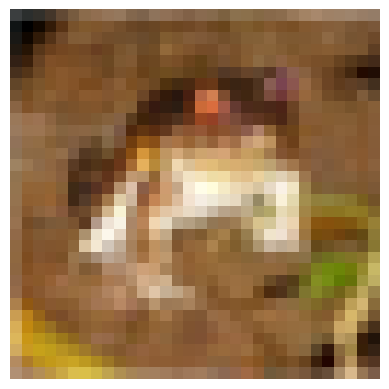

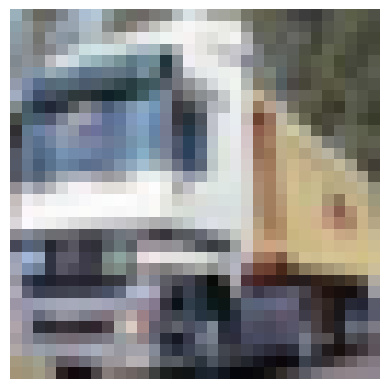

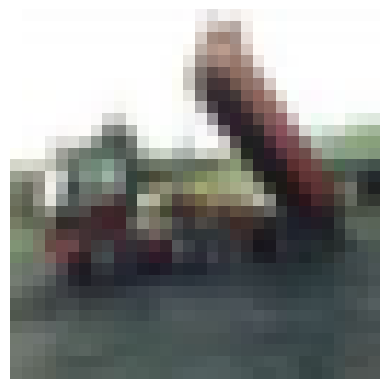

In [425]:
import matplotlib.pyplot as plt

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

num_images = 3
data_file_path = "data_batch_1"
data = unpickle(data_file_path)[b'data']
images = []

for i in range(num_images):
    color_img = data[i].reshape((3,32,32)).transpose(1,2,0)
    plt.imshow(color_img, interpolation='nearest')
    plt.axis('off')
    plt.show()
    color_img = (color_img - 127.5) / 127.5 # normalizing between [-1, 1]
    images.append(color_img)

color_enabled = True
num_neurons = 3072
W = np.zeros((num_neurons, num_neurons))

# # computes W_{ij} = V_i * V_j for all i and j. (Saves all images in weight matrix)
# norms = [np.linalg.norm(image) for image in images]
# min_norm = min(norms)

for image in images:
    W += np.outer(image, image) 

W = W / num_images
W = W / np.max(np.abs(W))
np.fill_diagonal(W, 0)

In [430]:
from scipy.integrate import solve_ivp

# constants
def g(u, beta = 0.005):
    return np.tanh(u * beta)

def sigmoid(u, scaling_factor=50):
    return 1 / (1 + np.exp(-u / scaling_factor))

tol = 1e-6 # integrate until converging to this tolerance
tau = 1.0
dt = 0.01

def hopfield_diff_eq(t, v):
    u = np.dot(W, v) # check if this is equivalent to sum(W_ij * V_j) for all j
    dvdt = (-v + g(u))/tau
    return dvdt

In [433]:
# If you want random noise, choose the top V. If you want to start it at a specific image, choose the bottom V.

V = np.random.uniform(-1.0, 1.0, size=(num_neurons))
# V = images[0].flatten()
# choice = np.random.choice(len(images))
# print(choice)
# V = images[choice].flatten()

time = 0 # for integration, this is the starting time at first
times = [time]
states = [V]

current_state = V
prev_state = V + 2 * tol # This makes the first iteration of the loop work

while np.abs(current_state - prev_state).max() > tol:
    prev_state = current_state
    result = solve_ivp(hopfield_diff_eq, (time, time + dt), current_state, method='RK45', t_eval=[time+dt])
    time += dt
    current_state = result.y[:, -1]

    times.append(time)
    states.append(current_state)

times = np.array(times)
states = np.array(states)


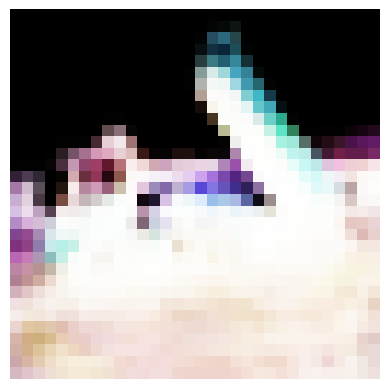

In [434]:
if color_enabled:
    final_img = states[-1].reshape((32,32,3))
else:
    final_img = states[-1].reshape((32,32))

final_img = (final_img+1)/2

if color_enabled:
    plt.imshow(final_img, interpolation='nearest')
else:
    plt.imshow(final_img, cmap="gray", interpolation='nearest')
plt.axis('off')
plt.show()

In [193]:
for image in images:
    print(np.linalg.norm(image))

11.693560332089058
14.889466611846942
20.715738065051404
